In [100]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Add project 1 to sys path 
import sys
sys.path.append('../project1/')
import tools as proj1_tools

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso

from IPython.display import clear_output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
import scipy.sparse as sp
np.random.seed(12)
import warnings
#Comment this to turn on warnings
warnings.filterwarnings('ignore')
### define Ising model params
# system size
L = 40
n = 20
# create 10000 random Ising states
states=np.random.choice([-1, 1], size=(n,L))
from project2_tools import ising_energies1D 

# calculate Ising energies
energies=ising_energies1D(states)

In [66]:
L = 40
n = 400

s=np.random.choice([-1, 1], size=(n,L))

E = ising_energies1D(s)
X = np.einsum('...i,...j->...ij',s,s) 

In [99]:
X_vectors = X.reshape(n,-1)

## One dimensional Ising model with linear regression

Fit the linear models and get the parameters; the coupling constant $J$

In [102]:
# OLS
regr_ols = proj1_tools.Regression(X_vectors, E, solve_method = 'svd')
J_fit_ols = regr_ols.beta

# Ridge and Lasso
lambdas = np.logspace(-10,0,11)

J_fit_ridge = []
J_fit_lasso = []
for i,lmbd in enumerate(lambdas):
    print('Lambdas: ',i+1,'/',lambdas.shape[0])
    regr_ridge = proj1_tools.Regression(X_vectors, E, lmbd = lmbd, solve_method = 'svd')
    J_fit_ridge.append(regr_ridge.beta)
    regr_lasso = Lasso(alpha=lmbd, fit_intercept=False)
    J_fit_lasso.append(regr_lasso.fit(X_vectors, E).coef_)
    clear_output(wait=0.1)

Lambdas:  11 / 11


### Plot

Parameters as matrix:

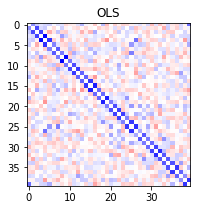

Lambda =  1e-10


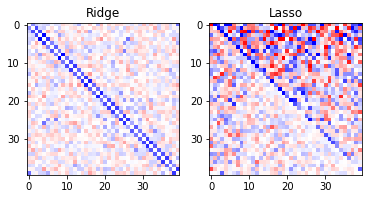

Lambda =  1e-09


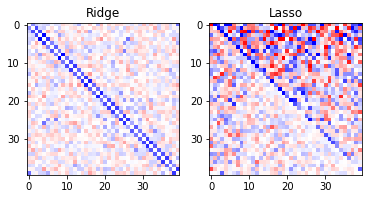

Lambda =  1e-08


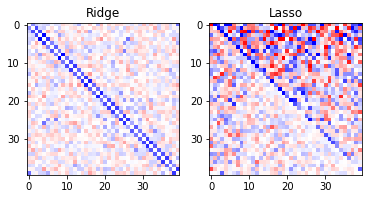

Lambda =  1e-07


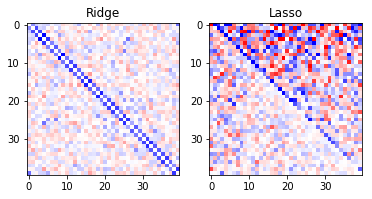

Lambda =  1e-06


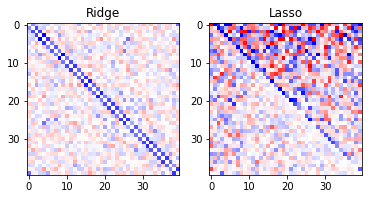

Lambda =  1e-05


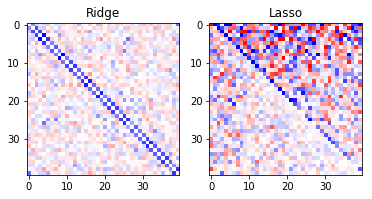

Lambda =  0.0001


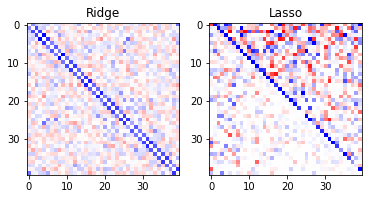

Lambda =  0.001


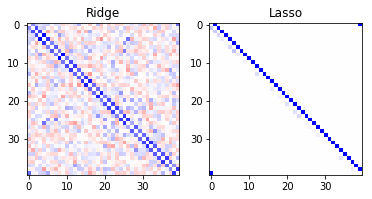

Lambda =  0.01


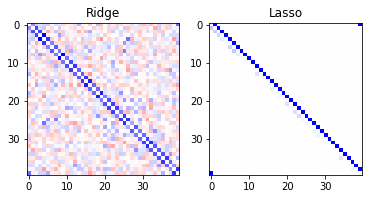

Lambda =  0.1


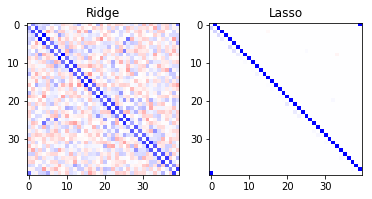

Lambda =  1.0


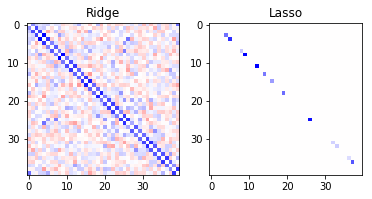

In [103]:
vmin = np.min(J_fit_ols)
assert vmin < 0
# OLS
plt.figure(figsize=[3,3])
plt.title('OLS')
plt.imshow(J_fit_ols.reshape((L,L)), vmin = vmin, vmax = - vmin, cmap = plt.cm.bwr)
plt.show()
# Ridge and Lasso
for i,lmbd in enumerate(lambdas):
    print('Lambda = ',lmbd)
    fig,[ax1,ax2] = plt.subplots(1,2)
    ax1.imshow(J_fit_ridge[i].reshape((L,L)), vmin = vmin, vmax = - vmin, cmap = plt.cm.bwr)
    ax1.set_title('Ridge')
    ax2.imshow(J_fit_lasso[i].reshape((L,L)), vmin = vmin, vmax = - vmin, cmap = plt.cm.bwr)
    ax2.set_title('Lasso')
    plt.show()
# plt.colorbar(m)

Histogram of paramters:

Lambda =  1e-10


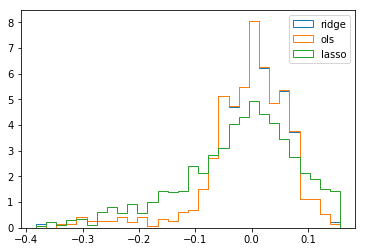

Lambda =  1e-09


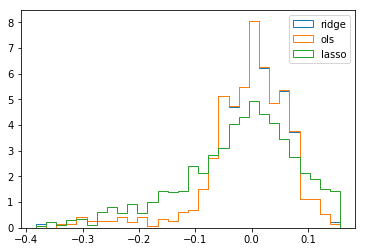

Lambda =  1e-08


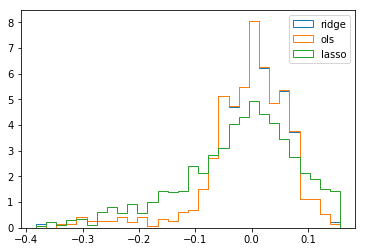

Lambda =  1e-07


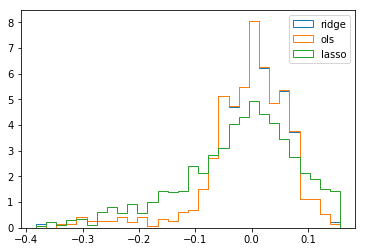

Lambda =  1e-06


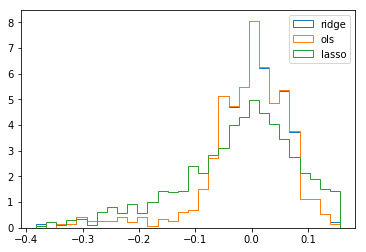

Lambda =  1e-05


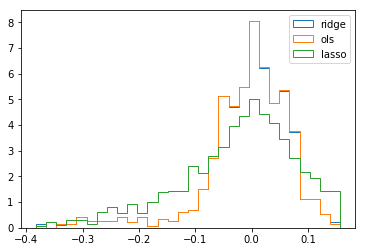

Lambda =  0.0001


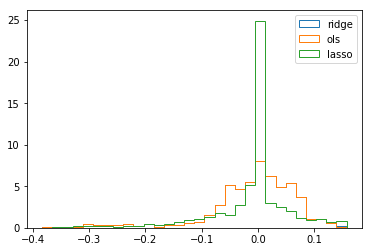

Lambda =  0.001


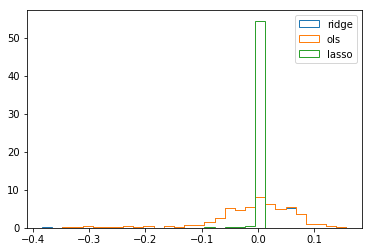

Lambda =  0.01


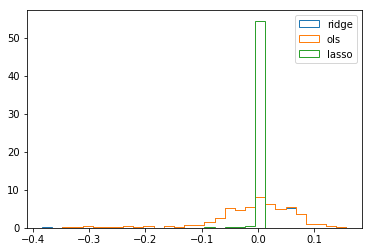

Lambda =  0.1


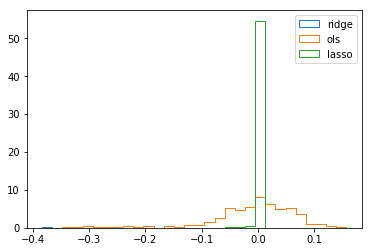

Lambda =  1.0


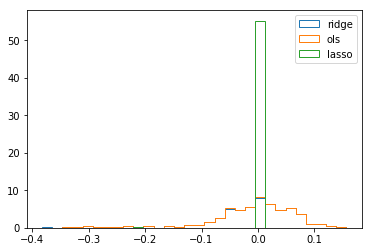

In [104]:
for i,lmbd in enumerate(lambdas):
    print('Lambda = ',lmbd)
    _,bins,_ = plt.hist(J_fit_ridge[i], bins = 30, histtype='step',density = True, label='ridge')
    _ = plt.hist(J_fit_ols, bins = bins, histtype='step', density = True, label='ols')
    _ = plt.hist(J_fit_lasso[i], bins = bins, histtype='step', density = True, label='lasso')
    plt.legend()
    plt.show()